# Movies feature graph

In [145]:
# Imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import ast

# Constants
ML_DATA_PATH = '../data/ml-100k-convert/'
GENERATED_PATH = '../generated/'
GRAPH_PATH = '../graphs/'

%matplotlib inline

In [146]:
movies = pd.read_csv(GENERATED_PATH+'final_movies.csv')

## Combining the tmdb and MovieLens dataset

<b>WE CAN SKIP THIS, CREATES THE 'FINAL_MOVIES.CSV' FILE </b>

In [45]:
# Load imdb datasets
tmdb_movies = pd.read_csv('datasets/tmdb_5000_movies.csv', delimiter=',') 
tmdb_movies_cast = pd.read_csv('datasets/tmdb_5000_credits.csv', delimiter=',') 

# Drop some columns and change index
tmdb_movies = tmdb_movies.drop(columns=["homepage", "status", "tagline", "overview", "original_title"])
tmdb_movies.head()

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",John Carter,6.1,2124


In [46]:
# Load MovieLens dataset
ML_links = pd.read_csv('datasets/ml-latest/links.csv', delimiter=',')
#ML_ratings = pd.read_csv('datasets/ml-latest-small/ratings.csv', delimiter=',') 
ML_links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
58093,193876,38566,78251.0
58094,193878,1754787,87558.0
58095,193880,5847740,422666.0
58096,193882,4453756,454439.0


We can only use the movies that are in the TMDB_5000, ml-latest and ml-100k datasets, 

In [47]:
# Load links of the movies to use
movie_links = pd.read_csv('datasets/ml_links.csv')
movie_links.head()

,ML-100k-convertId,ML-latestId
0,1,1
1,2,10
2,3,18
3,4,21
4,5,22


In [81]:
# Join ML_links and the total links
movies = ML_links.merge(movie_links, left_on="movieId", right_on="ML-latestId")
# Create a merge of the movies in tmdb 5000 and movielens
movies = tmdb_movies.merge(movies, left_on="id", right_on="tmdbId")
movies.head()

,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count,movieId,imdbId,tmdbId,ML-100k-convertId,ML-latestId
0,200000000,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...",597,"[{""id"": 2580, ""name"": ""shipwreck""}, {""id"": 298...",en,100.025899,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-11-18,1845034188,194.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Titanic,7.5,7562,1721,120338,597.0,313,1721
1,175000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",9804,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 331, ""na...",en,44.640292,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1995-07-28,264218220,135.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Waterworld,5.9,992,208,114898,9804.0,554,208
2,125000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",415,"[{""id"": 848, ""name"": ""double life""}, {""id"": 84...",en,50.073575,"[{""name"": ""PolyGram Filmed Entertainment"", ""id...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1997-06-20,238207122,125.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Batman & Robin,4.2,1418,1562,118688,415.0,254,1562
3,116000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",9619,"[{""id"": 720, ""name"": ""helicopter""}, {""id"": 141...",en,16.904440,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1997-02-07,178127760,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Dante's Peak,5.7,428,1438,118928,9619.0,323,1438
4,110000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...",714,"[{""id"": 212, ""name"": ""london england""}, {""id"":...",en,42.887121,"[{""name"": ""Eon Productions"", ""id"": 7576}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",1997-12-11,333011068,119.0,"[{""iso_639_1"": ""de"", ""name"": ""Deutsch""}, {""iso...",Tomorrow Never Dies,6.0,925,1722,120347,714.0,751,1722


In [82]:
# id is tmdbId and ML-latestId is movieId
# From now on use tmdbId as the real ID
movies.drop(columns=["tmdbId", "movieId"], inplace=True)
movies.to_csv("datasets/final_movies.csv", index=False)

In [57]:
movies.shape

(480, 18)

The combined dataset of the ML_latest, ML_100k and tmdb contains 480 movies

## Feature networks

There are many possible networds we could create from the features. 

We will explore and possibly make the following graphs:
* genres
* keywords
* revenue & budget
* language
* production company


In [147]:
def strdict_to_column(strdict, name):
    """
    Converts a dict (in string format) to a list of the values
    e.g. [{"id": 18, "name": "Drama"}, {"id": 10749, "Action"}] -> ["Drama", "Action"]
    """
    list_dicts = strdict.apply(lambda x: ast.literal_eval(x))
    # Convert list of dicts to list of keywords/genres
    _list = list_dicts.apply(lambda x: [d['name'] for d in x ])
    df = pd.DataFrame(_list)
    df = df.explode(name)
    df['count'] = 1
    # Pivot so 'name' becomes columns
    df = df.pivot(columns=name, values='count').fillna(0)
    return df

In [148]:
def distance_to_weight():
    # Let us use the Gaussian function
    kernel_width = distances.mean()
    weights_list = np.exp(-distances**2 / kernel_width**2)

In [149]:
def epsilon_similarity_graph(distances: np.ndarray, alpha=1, epsilon=0):
    """ X (n x n): distance matrix
        alpha (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    X = distances.copy()
    X[X > epsilon] = np.inf
    adjacency = np.exp( - X ** 2 / alpha)
    np.fill_diagonal(adjacency, 0)
    return adjacency

### Genre network

Here, we use the item dataset of ml-100k-convert

In [251]:
movie_genres = movies["genres"]
movie_genres_matrix = strdict_to_column(movie_genres, "genres")
genres = list(movie_genres_matrix.columns)

In [333]:
len(genres)

19

In [151]:
movie_genres_matrix.head()

genres,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


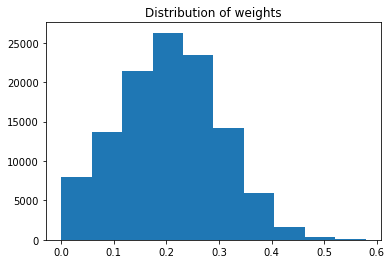

In [252]:
# 1 means completely similar
genre_distances = pdist(movie_genres_matrix, 'hamming')
plt.hist(genre_distances)
plt.title('Distribution of weights')
plt.show()

In [253]:
unique, counts = np.unique(genre_distances, return_counts=True)
dict(zip(unique, counts))

{0.0: 1593,
 0.05263157894736842: 6433,
 0.10526315789473684: 13624,
 0.15789473684210525: 21439,
 0.21052631578947367: 26272,
 0.2631578947368421: 23458,
 0.3157894736842105: 14226,
 0.3684210526315789: 5906,
 0.42105263157894735: 1637,
 0.47368421052631576: 326,
 0.5263157894736842: 44,
 0.5789473684210527: 2}

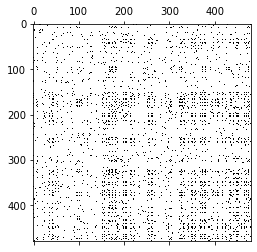

In [571]:
# Connected when all genres the same or one difference
genre_adjacency = squareform(np.where(genre_distances<0.10,1,0))
plt.spy(genre_adjacency)
plt.show()

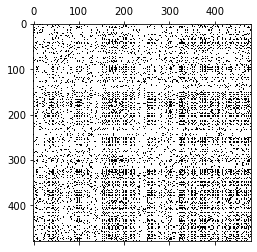

In [586]:
alpha = 0.25
epsilon = 0.15
genre_adjacency = epsilon_similarity_graph(squareform(genre_distances), alpha=alpha, epsilon=epsilon)
plt.spy(genre_adjacency)
plt.show()

In [587]:
np.savetxt(GENERATED_PATH+'movie_genre_adj.csv', genre_adjacency, delimiter=',')

In [155]:
# Add labels for visualisation in Gephi
movie_genres_matrix['label'] = movie_genres_matrix.apply(lambda x: [genre for genre in genres if x[genre] != 0], axis=1)
movie_genres_matrix['label'] = movie_genres_matrix.apply(lambda x: {0: '-'.join(x['label'])}, axis=1)
movie_genres_matrix['label']

0           {0: 'Animation-Comedy-Family'}
1         {0: 'Action-Adventure-Thriller'}
2                      {0: 'Comedy-Crime'}
3             {0: 'Comedy-Crime-Thriller'}
4                    {0: 'Drama-Thriller'}
                      ...                 
475           {0: 'Action-Family-Fantasy'}
476    {0: 'Crime-Drama-Mystery-Thriller'}
477                          {0: 'Comedy'}
478                    {0: 'Comedy-Crime'}
479    {0: 'Comedy-Drama-Fantasy-Romance'}
Name: label, Length: 480, dtype: object

In [156]:
# Export for use in Gephi
graph = nx.from_numpy_array(genre_adjacency)
nx.set_node_attributes(graph, movie_genres_matrix['label'])
nx.write_gexf(graph, GRAPH_PATH+'movie_genres.gexf')

### Keywords network

In [629]:
def strdict_to_column_keywords(strdict, name):
    """
    Converts a dict (in string format) to a list of the values
    e.g. [{"id": 18, "name": "Drama"}, {"id": 10749, "Action"}] -> ["Drama", "Action"]
    """
    list_dicts = movie_keywords.apply(lambda x: ast.literal_eval(x))
    # Convert list of dicts to list of keywords/genres
    _list = list_dicts.apply(lambda x: [d['name'] for d in x ])
    df = pd.DataFrame(_list)
    df = df.explode(name)
    # Keep only first word of index
    df[name] = df.apply(lambda x: str(x[name]).split()[0], axis=1)
    df['count'] = 1
    df = df.reset_index()
    df = df.drop_duplicates()
    # Pivot so 'name' becomes columns
    df = df.pivot(index='index', columns=name, values='count').fillna(0)
    return df

In [630]:
movie_keywords = movies["keywords"]
movie_keywords_matrix = strdict_to_column_keywords(movie_keywords, "keywords")
keywords = list(movie_keywords_matrix.columns)

In [631]:
movie_keywords_matrix

keywords,15th,17th,18th,1910s,1930s,1940s,1950s,1960s,1970s,1990s,...,wrong,wrongful,wyatt,wyoming,x-ray,xenomorph,yellow,young,yuppie,zombie
index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [696]:
movie_keywords_matrix.sum(axis=1).mean()

9.808333333333334

<function matplotlib.pyplot.show(*args, **kw)>

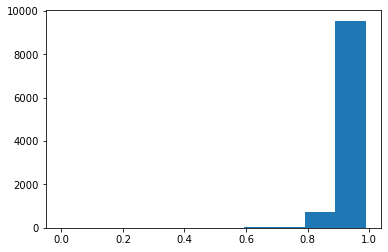

In [632]:
keyword_distances = pdist(movie_keywords_matrix,'jaccard')
plt.hist(keyword_distances[keyword_distances != 1])
plt.show

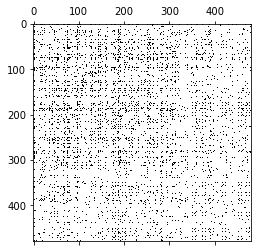

In [633]:
keyword_adjacency = squareform(np.where(keyword_distances < 1 , 1 , 0))
plt.spy(keyword_adjacency)
plt.show()

In [634]:
keyword_distances

array([1.        , 0.93333333, 1.        , ..., 1.        , 1.        ,
       1.        ])

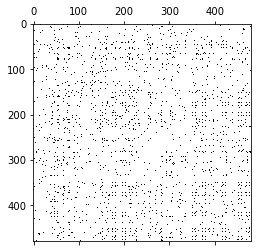

In [635]:
alpha = 0.25
epsilon = 0.95
keyword_adjacency = epsilon_similarity_graph(squareform(keyword_distances), alpha=alpha, epsilon=epsilon)
plt.spy(keyword_adjacency)
plt.show()

In [636]:
np.savetxt(GENERATED_PATH+'movie_keyword_adj.csv', keyword_adjacency, delimiter=',')

In [637]:
# Add labels for visualisation in Gephi

# First keyword is float (nan), remove
#keywords.pop(0)

movie_keywords_matrix['label'] = movie_keywords_matrix.apply(lambda x: [keyword for keyword in keywords if x[keyword] != 0], axis=1)
movie_keywords_matrix['label'] = movie_keywords_matrix.apply(lambda x: {0: '-'.join(x['label'])}, axis=1)
movie_keywords_matrix['label']

index
0      {0: 'boy-friends-friendship-jealousy-new-rival...
1      {0: 'computer-cossack-cuba-ejection-electromag...
2      {0: 'bet-episode-hoodlum-hotel-los-new-sperm-w...
3      {0: 'based-business-con-crime-debt-drug-gambli...
4      {0: 'cowardliness-police-psychologist-psycholo...
                             ...                        
475           {0: 'american-chinese-kangaroo-mythology'}
476     {0: 'confidence-dialogue-independent-invention'}
477                    {0: 'invention-inventor-scandal'}
478                   {0: 'head-mexico-murder-vacation'}
479    {0: 'alternative-ambiguous-chance-commercial-d...
Name: label, Length: 480, dtype: object

In [638]:
graph = nx.from_numpy_array(keyword_adjacency)
nx.set_node_attributes(graph, movie_keywords_matrix['label'])
nx.write_gexf(graph, GRAPH_PATH+'movie_keywords.gexf')

### Buget & Revenue network

In [164]:
movies_revenue = movies[['id', 'title', 'revenue', 'budget']]
print(np.sum((movies_revenue['budget'] == 0)))
print(np.sum((movies_revenue['revenue'] == 0)))

51
86


A lot of data is unknown (86/480), so this metric is not really usable

### Original language network

In [165]:
language = movies[['original_language']]
language['original_language'].value_counts()

en    474
it      2
fr      1
ja      1
cn      1
de      1
Name: original_language, dtype: int64

As most movies are english, language isn't a good metric either

### Production company

In [516]:
def strdict_to_column_companies(strdict, name):
    """
    Converts a dict (in string format) to a list of the values
    e.g. [{"id": 18, "name": "Drama"}, {"id": 10749, "Action"}] -> ["Drama", "Action"]
    """
    list_dicts = strdict.apply(lambda x: ast.literal_eval(x))
    # Convert list of dicts to list of keywords/genres
    _list = list_dicts.apply(lambda x: [d['name'] for d in x ])
    df = pd.DataFrame(_list)
    df = df.explode(name)
    df['production_companies'] = df.apply(lambda x: company_tranform(str(x['production_companies'])), axis=1)
    df['count'] = 1
    df = df.reset_index()
    df = df.drop_duplicates()
    # Pivot so 'name' becomes columns
    df = df.pivot(index='index', columns=name, values='count').fillna(0)
    return df

# We could see that some companies have a slightly different name, but should be the same: 
# Act III & Act III Communications
# Alphaville Films & Alphaville Productions 
# Canal Plus & Canal+
# Columbia Pictures & Columbia Pictures Corporation & Columbia Pictures Industries
# ...
def company_tranform(company):
    if company == "Act III Communications":
        return "Act III"
    if company == "Alphaville Productions":
        return "Alphaville Films"
    if company == "Constellation Entertainment":
        return "Constellation Films"
    if company == "Detour Film Production":
        return "Detour Filmproduction"
    if company == "Dino de Laurentiis Cinematografica":
        return "Dino De Laurentiis Company"
    if company == "Hemdale Film Corporation":
        return "Hemdale Film"
    if company == "Polar Entertainment":
        return "Polar Productions"
    if company == "Renaissance Pictures":
        return "Renaissance Films"
    if company == "Taurus Films":
        return "Taurus Film"
    if "Samuel Goldwyn Company" in company:
        return "Samuel Goldwyn Company"    
    if "Fox" in company:
        return "Fox"
    if "BBC" in company:
        return "BBC"
    if "Columbia Pictures" in company:
        return "Columbia Pictures"
    if "MPCA" in company:
        return "MPCA"
    if "Paramount" in company:
        return "Paramount"
    if "Disney" in company:
        return "Disney"
    if "Warner Bros" in company:
        return "Warner Bros"
    return company

In [524]:
movie_companies = movies['production_companies']
movie_companies_matrix = strdict_to_column_companies(movie_companies, 'production_companies')
companies = list(movie_companies_matrix.columns)

In [694]:
movie_companies_matrix.sum(axis=1).mean()

2.2666666666666666

As with the keywords, we will use the Jaccard similarity

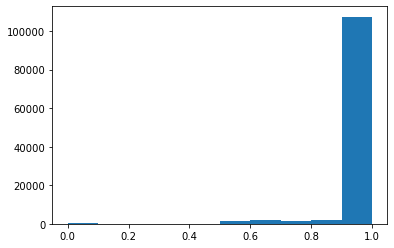

In [528]:
company_distances = pdist(movie_companies_matrix,'jaccard')
plt.hist(company_distances)
plt.show()

In [666]:
pd.DataFrame(squareform(company_distances)).iloc[13,421]

0.0

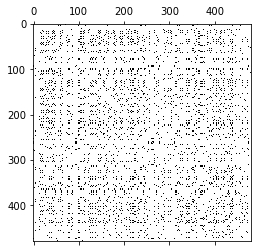

In [529]:
company_adjacency = squareform(np.where(company_distances < 1 , 1 , 0))
plt.spy(company_adjacency)
plt.show()

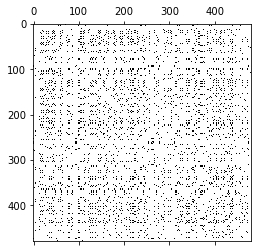

In [682]:
alpha = 0.25
epsilon = 0.95
company_adjacency = epsilon_similarity_graph(squareform(company_distances), alpha=alpha, epsilon=epsilon)
plt.spy(company_adjacency)
plt.show()

In [686]:
np.savetxt(GENERATED_PATH+'movie_company_adj.csv', company_adjacency, delimiter=',')

In [684]:
# Add labels for visualisation in Gephi

movie_companies_matrix['label'] = movie_companies_matrix.apply(lambda x: [company for company in companies if x[company] != 0], axis=1)
movie_companies_matrix['label'] = movie_companies_matrix.apply(lambda x: {0: '-'.join(x['label'])}, axis=1)
movie_companies_matrix['label']

index
0                         {0: 'Pixar Animation Studios'}
1                  {0: 'Eon Productions-United Artists'}
2                      {0: 'A Band Apart-Miramax Films'}
3          {0: 'Jersey Films-Metro-Goldwyn-Mayer (MGM)'}
4        {0: 'New Regency Pictures-Regency Enterprises'}
                             ...                        
475    {0: 'China Film Co-Production Corporation-IJL ...
476    {0: 'Jasmine Productions Inc.-Jean Doumanian P...
477                            {0: '101st Street Films'}
478    {0: 'Brad Krevoy & Steve Stabler production-Or...
479    {0: 'Intermedia Films-Mirage Enterprises-Miram...
Name: label, Length: 480, dtype: object

In [685]:
graph = nx.from_numpy_array(company_adjacency)
nx.set_node_attributes(graph, movie_companies_matrix['label'])
nx.write_gexf(graph, GRAPH_PATH+'movie_companies.gexf')

## Combining feature networks

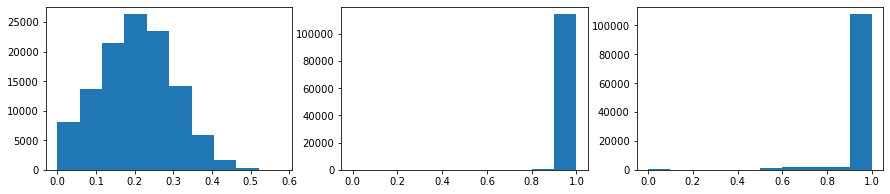

In [533]:
plt.figure(1,figsize=(15,3))

plt.subplot(131)
plt.hist(genre_distances)

plt.subplot(132)
plt.hist(keyword_distances)

plt.subplot(133)
plt.hist(company_distances)

plt.show()

As expected, keyword_distances and company_distances are mostly around one, as the sets are very big

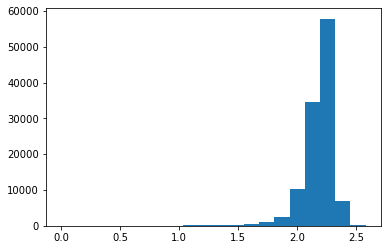

In [697]:
genre_factor = 1
keyword_factor = 1
company_factor = 1
movie_distances = genre_factor*genre_distances + keyword_factor*keyword_distances + company_factor*company_distances
#movie_distances = np.where(movie_distances<0,0,movie_distances)
plt.hist(movie_distances, bins=20)
plt.show()

In [328]:
def epsilon_similarity_graph(distances: np.ndarray, alpha=1, epsilon=0):
    """ X (n x n): distance matrix
        alpha (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    X = distances.copy()
    X[X > epsilon] = np.inf
    adjacency = np.exp( - X ** 2 / alpha)
    np.fill_diagonal(adjacency, 0)
    return adjacency

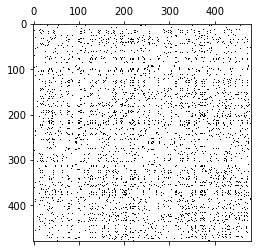

In [698]:
alpha = 1
epsilon = 2

adjacency = epsilon_similarity_graph(squareform(movie_distances), alpha=alpha, epsilon=epsilon)
adjacency = np.where(adjacency < 0.001, 0, adjacency)
plt.spy(adjacency)
plt.show()

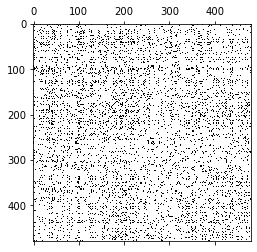

In [195]:
movie_adjacency = squareform(np.where(movie_distances >= 1,1,0))
plt.spy(movie_adjacency)
plt.show()

In [699]:
np.savetxt(GENERATED_PATH+'movie_features_adj.csv', adjacency, delimiter=',')

In [700]:
movie_labels=pd.DataFrame()
# Add labels for visualisation in Gephi
movie_genres_matrix['label'] = movie_genres_matrix.apply(lambda x: [genre for genre in genres if x[genre] != 0], axis=1)
movie_labels['genre'] = movie_genres_matrix.apply(lambda x: {0: '-'.join(x['label'])}, axis=1)

movie_keywords_matrix['label'] = movie_keywords_matrix.apply(lambda x: [keyword for keyword in keywords if x[keyword] != 0], axis=1)
movie_labels['keyword'] = movie_keywords_matrix.apply(lambda x: {1: '-'.join(x['label'])}, axis=1)


movie_companies_matrix['label'] = movie_companies_matrix.apply(lambda x: [company for company in companies if x[company] != 0], axis=1)
movie_labels['company'] = movie_companies_matrix.apply(lambda x: {2: '-'.join(x['label'])}, axis=1)
movie_labels

,genre,keyword,company
0,{0: 'Animation-Comedy-Family'},{1: 'boy-friends-friendship-jealousy-new-rival...,{2: 'Pixar Animation Studios'}
1,{0: 'Action-Adventure-Thriller'},{1: 'computer-cossack-cuba-ejection-electromag...,{2: 'Eon Productions-United Artists'}
2,{0: 'Comedy-Crime'},{1: 'bet-episode-hoodlum-hotel-los-new-sperm-w...,{2: 'A Band Apart-Miramax Films'}
3,{0: 'Comedy-Crime-Thriller'},{1: 'based-business-con-crime-debt-drug-gambli...,{2: 'Jersey Films-Metro-Goldwyn-Mayer (MGM)'}
4,{0: 'Drama-Thriller'},{1: 'cowardliness-police-psychologist-psycholo...,{2: 'New Regency Pictures-Regency Enterprises'}
...,...,...,...
475,{0: 'Action-Family-Fantasy'},{1: 'american-chinese-kangaroo-mythology'},{2: 'China Film Co-Production Corporation-IJL ...
476,{0: 'Crime-Drama-Mystery-Thriller'},{1: 'confidence-dialogue-independent-invention'},{2: 'Jasmine Productions Inc.-Jean Doumanian P...
477,{0: 'Comedy'},{1: 'invention-inventor-scandal'},{2: '101st Street Films'}
478,{0: 'Comedy-Crime'},{1: 'head-mexico-murder-vacation'},{2: 'Brad Krevoy & Steve Stabler production-Or...


In [701]:
graph = nx.from_numpy_array(adjacency)
nx.set_node_attributes(graph, movie_labels['genre'])
nx.set_node_attributes(graph, movie_labels['keyword'])
nx.set_node_attributes(graph, movie_labels['company'])
nx.write_gexf(graph, GRAPH_PATH+'movie_features.gexf')